# Setup



In [0]:
%%capture
%pip install poetry
%pip install git+https://github.com/oughtinc/ergo.git@993c959d4b5dc5b398f02b842407814b79619a42
%pip install xlrd

In [0]:
%load_ext google.colab.data_table

In [0]:
%%capture
import ergo
import numpy as np
import pandas as pd
import ssl
import math
import datetime
import warnings
import functools
from datetime import timedelta, date
from ergo.contrib.el_paso import *

In [0]:
warnings.filterwarnings(module="plotnine", action="ignore")
warnings.filterwarnings(module="jax", action="ignore")
ssl._create_default_https_context = ssl._create_unverified_context

In [0]:
metaculus = ergo.Metaculus(
    username="oughtpublic", 
    password="123456",
    api_domain = "pandemic"
)

# Ergo extensions



We'll define some helper functions that might get moved into Ergo in the
future.



In [0]:
START_DATE = date(2020, 4, 1)


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)


# Rejection sampling

def rejection_sample(fn, condition):
    """
    Sample from fn until we get a value that satisfies
    condition, then return it.
    """
    while True:        
        value = fn()
        if condition(value):
            return value


# Memoization

memoized_functions = []

def mem(func):
    func = functools.lru_cache(None)(func)
    memoized_functions.append(func)
    return func

def clear_mem():
    for func in memoized_functions:
        func.cache_clear()


# Associate models with questions

# We'll add a sampler here for each question we predict on. 
# Each sampler is a function that returns a single sample
# from our model predicting on that question.
samplers = {}

def question(question_id, community_weight=0, community_fn=None):
    q = metaculus.get_question(question_id)

    def decorator(func):
        tag = func.__name__

        @functools.wraps(func)
        @mem
        def sampler():
            if ergo.flip(community_weight):
                if community_fn:
                    value = community_fn()
                else:
                    value = q.sample_community()
            else:
                value = func()
            if isinstance(value, date):
                # FIXME: Ergo needs to handle dates
                ergo.tag(int((value - START_DATE).days), tag)
            else:
                ergo.tag(value, tag)
            return value
        sampler.question = q
        samplers[q.id] = sampler
        return sampler
    return decorator

def summarize_question_samples(samples):
    sampler_tags = [sampler.__name__ for sampler in samplers.values()]
    tags_to_show = [tag for tag in sampler_tags if tag in samples.columns]
    samples_to_show = samples[tags_to_show]
    summary = samples_to_show.describe().transpose().round(2)
    display(summary)

def plot_question(sampler, num_samples=200, bw=None):
  def model():
      clear_mem()
      sampler()

  samples = ergo.run(model, num_samples=num_samples)

  summarize_question_samples(samples)

  q = sampler.question

  q_samples = samples[sampler.__name__]

  if q.id == 4128: # Date question: Need to convert back to date from days (https://github.com/oughtinc/ergo/issues/144)
      q_samples = np.array([START_DATE + timedelta(s) for s in q_samples])

  if bw is not None:
      q.show_prediction(samples=q_samples, show_community=True, percent_kept=0.9, bw=bw)
  else:
      q.show_prediction(samples=q_samples, show_community=True, percent_kept=0.9)


def sample_from_ensemble(models, params, weights=None, fallback=False, default=None):
    """Sample models in proportion to weights and execute with
    model_params. If fallback is true then call different model from
    ensemble if the selected model throws an error. If Default is not
    None then return default if all models fail

    """

    model = ergo.random_choice(models, weights)
    try:
        result = model(**params)
        if np.isnan(result):
            raise KeyError
        return result
    except:
        if fallback and len(models) > 1:
            i = models.index(model)
            del models[i]
            del weights[i]
            return sample_from_ensemble(models, params, weights, fallback, default)
        elif default is not None:
            return default

# External data (cases, estimates, models)



## Texas government cases data



In [7]:
el_paso_cases = texas_data.get_el_paso_data()

el_paso_cases

,Cases so far,New cases
2020-03-04,0,NaN
2020-03-05,0,0
2020-03-06,0,0
2020-03-09,0,0
2020-03-10,0,0
2020-03-11,0,0
2020-03-12,0,0
2020-03-13,0,0
2020-03-15,1,1
2020-03-16,1,0


## @onlyasith's cases model



Pulled from
[here](https://docs.google.com/spreadsheets/d/1L6pzFAEJ6MfnUwt-ea6tetKyvdi0YubnK_70SGm436c/edit#gid=1807978187)



In [8]:
projected_cases = onlyasith.get_onlyasith_results()

projected_cases

,Cases so far,New cases
Date,,
2020-04-04,96,NaN
2020-04-05,106,10.0
2020-04-06,115,9.0
2020-04-07,125,10.0
2020-04-08,153,28.0
...,...,...
2020-09-30,1090,0.0
2020-10-01,1090,0.0
2020-10-02,1091,1.0


## Shaman et al. model of confirmed cases



[research
article](https://www.medrxiv.org/content/10.1101/2020.03.21.20040303v2)

Pulled from [here](https://github.com/shaman-lab/COVID-19Projection)



In [0]:
scenarios = ["Projection_nointerv", "Projection_60contact", "Projection_70contact", "Projection_80contact"]
cu_model_data = {}
for scenario in scenarios:
    df = pd.read_csv(f"https://raw.githubusercontent.com/shaman-lab/COVID-19Projection/master/Projection_April26/{scenario}.csv", parse_dates=["Date"])
    df = df[df.county == "El Paso County TX"]
    df["Date"] = df["Date"].apply(lambda x: x.date())
    df.set_index("Date", inplace = True)

    cu_model_data[scenario] = df



@mem
def cu_model_scenario():
    """Which of the model scenarios are we in?"""
    return ergo.random_choice([s for s in cu_model_data.keys()])

@mem
def cu_model_quantile():
    """Where in the distribution of model outputs are we for this model run?
    Want to be consistent across time, so we sample it once per model run"""
    return ergo.uniform()

## @KrisMoore's compiled data



Pulled from
[here](https://docs.google.com/spreadsheets/d/1eGF9xYmDmvAkr-dCmd-N4efHzPyYEfVl0YmL9zBvH9Q/edit#gid=1694267458)



In [10]:
compiled_data = krismoore.get_krismoore_data()

compiled_data

,cases,new_cases,2_day_sma_new_cases,presumed_active_cases,fatalities,recovered,In hospital confirmed,in_icu,on_ventilator,tests_el_paso_dpt_public_health_only,new_tests_el_paso_dpt_public_health_only,tests_el_paso_inc_other_labs,tests_texas_all_sources,population
date,,,,,,,,,,,,,,
2020-03-04,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"952,366"
2020-03-05,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-06,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## @brachbach model (cases -> hospitalized)



In [0]:
get_daily_hospital_confirmed = brachbach.get_daily_hospital_confirmed

# Model components



Many of the Metaculus questions are asking to quantify the result of
complex causal processes. To answer 'How many total patients are in
the ICU on [date]?' requires a specification of which factors lead to
an ICU patient&#x2014;from the societal processes that are adopted ->
exposure risk -> disease development trajectory -> number of icu
patients. We adopt the approach of trying to explicitly specify the
causal process underlying each question. In this section we model some
of the relevant variables we will make use of in the next section's
models. We will take an ensemble of models approach. We will therefore
sometimes specify multiple models for each variable we are interested
in. These models can be mixed together to (hopefully) result in more
robust predictions.  Ultimately the mixture parameter would be a
random variable conditioned on the model's success. At the moment it
is a parameter for the modeler to explicitly tune.



## Daily Infections



Shaman Model



In [0]:
def daily_infections_cu_model(date: date) -> int:
    """
    Predict the number of reported (new) Covid-19 infections on [date]
    using the Columbia model
    """
    scenario = cu_model_scenario()
    quantile = cu_model_quantile()

    # Extract quantiles of the model distribution
    xs = np.array([0.025, 0.25, 0.5, 0.75, 0.975])
    ys = np.array([
        cu_model_data[scenario][s][date] for s in ["report_2.5", "report_25", "report_50", "report_75", "report_97.5"]
    ])
    # Linearly interpolate
    return int(round(np.interp(quantile, xs, ys)))

onlyasith model+



In [0]:
@mem
def daily_infections_base_model(date: date) -> int:
    """
    What is the number of reported (new) Covid-19 infections on [date]?
    """
    try:
        # Look up projections from @onlyasith's model
        cases = projected_cases.loc[date, "New cases"]
        if np.isnan(cases):
            raise KeyError

        # Add some (fairly arbitrary) uncertainty around this point estimate
        if cases == 0:
          return cases
        cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
        return int(np.clip(cases_estimate, cases * 0.5, cases * 2).round())
    except KeyError:
        # We're beyond the time range for data and model
        return 0

Sample from ensemble



In [0]:
@mem
def daily_infections(date: date) -> int:
    """
    What is the number of reported (new) Covid-19 infections on [date]?
    """

    try:  # try to use existing data
        new_cases = el_paso_cases.loc[date, "New cases"]
        if np.isnan(new_cases):
            raise KeyError
        return new_cases
    except KeyError:  # if there isn't existing data, use our ensemble of models
        return sample_from_ensemble([daily_infections_cu_model, daily_infections_base_model], {date: date}, [.8, .2], fallback=True, default=0)

### Case-based variables (mean, sma, peak)



In [0]:
@mem
def mean_infections(start_date: date, end_date: date):
    """
    What is the average number of reported new infections for this range of 
    dates? (Including start date, excluding end date)
    """
    days = daterange(start_date, end_date)
    return np.mean([daily_infections(day) for day in days])

In [0]:
@mem
def sma_infections(date: date):
    """
    The simple moving average of infections for a date.

    Defined in https://pandemic.metaculus.com/questions/4128:

    'The 2-day SMA is defined as the unweighted average (arithmetic mean)
    over the current day and the previous day.'
    """
    return mean_infections(date - timedelta(1), date + timedelta(1))

@mem
def peak_compatible_with_historical_data(peak_date):
    if not peak_date in el_paso_cases.index:
        return True
    for comparison_date in daterange(START_DATE, peak_date + timedelta(11)):
        if comparison_date not in el_paso_cases.index:
            continue
        if sma_infections(comparison_date) > sma_infections(peak_date):
            return False
        if sma_infections(comparison_date) == sma_infections(peak_date) and comparison_date > peak_date:
            return False
    return True


@mem
def peak_infection_date_community():
    """
    The community assigns probability to some dates in the past
    that we already know were not the peak.
    So instead of sampling from the full community distribution,
    sample from the portion of the community distribution
    that is plausibly correct.
    """    
    peak_date = rejection_sample(
        peak_infection_date.question.sample_community, 
        peak_compatible_with_historical_data)
    return peak_date

## Confirmed Hospital Patients



Model from Shaman et al.



In [0]:
@mem
def get_hospital_confirmed_from_daily_infected_model():

    # from https://penn-chime.phl.io/
    hospital_stay_days_point_estimate = 7

    hospital_stay_days_fuzzed = round(
        float(ergo.normal_from_interval(
            hospital_stay_days_point_estimate * 0.5,
            hospital_stay_days_point_estimate * 1.5
        ))
    )

    hospital_stay_days = max(1, hospital_stay_days_fuzzed)

    has_hospital_confirmed = compiled_data[compiled_data["In hospital confirmed"].notna()]

    data_dates = has_hospital_confirmed.index

    # for each date for which we have data for how many lab-confirmed COVID patients were in the hospital,
    # how many new confirmed cases were there over the past hospital_stay_days days?
    def get_recent_infected_data(date):
      return sum([daily_infections(date - timedelta(n))
        for n in range(0, hospital_stay_days)])

    recent_infected_data = [[get_recent_infected_data(date)]
      for date in data_dates]

    reg = LinearRegression(fit_intercept=False).fit(
        recent_infected_data,
        has_hospital_confirmed["In hospital confirmed"])

    # TODO: consider adding uncertainty to the fit here

    # now that we've related current hospitalized cases and recent confirmed cases,
    # return a function that allows us to predict hospitalized cases given estimates
    # of future confirmed cases
    def hospital_confirmed_from_daily_infected_model(date: date):
      recent_infected = sum([daily_infections(date - timedelta(n))
        for n in range(0, hospital_stay_days)])
      return int(round(reg.predict([[recent_infected]])[0]))

    return hospital_confirmed_from_daily_infected_model

@mem
def hospital_confirmed_for_date(date: date) -> int:
    """
    The total number of lab-confirmed COVID-19 
    patients in El Paso County in the hospital on this date
    """

    # We predict the number of lab-confirmed COVID patients
    # in the hospital on some date
    # as some multiple of the number of new confirmed COVID cases
    # over the past 7 or so days
    # (since someone who gets admitted to the hospital for COVID
    # will probably stay there for 7 or so days)

    hospital_confirmed_from_daily_infected_model = get_hospital_confirmed_from_daily_infected_model()

    try:
      new_hospital_confirmed = compiled_data.loc[date, "In hospital confirmed"]
      if np.isnan(new_hospital_confirmed):
        raise KeyError
      return new_hospital_confirmed
    except KeyError:
      return hospital_confirmed_from_daily_infected_model(date)

@brachbach model



In [0]:
# Build @brachbach model
hospital_confirmed_from_daily_infected_model = get_daily_hospital_confirmed(compiled_data, daily_infections)

@mem
def hospital_confirmed_for_date(date: date) -> int:
    """
    The total number of lab-confirmed COVID-19 patients in El Paso County in
    the hospital on this date
    """
    try:
        # Look up in-hospital confirmed cases from @KrisMoore's compiled data
        new_hospital_confirmed = compiled_data.loc[date, "In hospital confirmed"]
        if np.isnan(new_hospital_confirmed):
            raise KeyError
        return new_hospital_confirmed
    except KeyError:
        try:
            # Get point estimate from @brachbach's regression model
            cases = hospital_confirmed_from_daily_infected_model(date)

            # Add some (fairly arbitrary) uncertainty around this point estimate
            if cases == 0:
              return cases
            cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
            return np.clip(cases_estimate, cases * 0.5, cases * 2)
        except KeyError:
            return 0

## Proportion ICU admissions requiring ventilation



In [0]:
@mem
def frac_icu_ventilation():
    """
    Proportion of ICU admissions requiring ventilation

    Approach (PabloStafforini et al): 
    https://pandemic.metaculus.com/questions/4154/#comment-28155

    TODO: 
    - Improve how we use case data
    - Add qualitative adjustments
    """
    ventilation_pseudocounts = 25 + 17 + 0.05 * 1150 + 0.1 * 132
    icu_pseudocounts = 100 + 36 + 0.05 * 1300 + 0.1 * 196
    return ergo.beta_from_hits(ventilation_pseudocounts, icu_pseudocounts)

# El Paso questions



,count,mean,std,min,25%,50%,75%,max
peak_infection_date,200.0,37.14,29.51,25.0,25.0,25.0,25.0,139.0


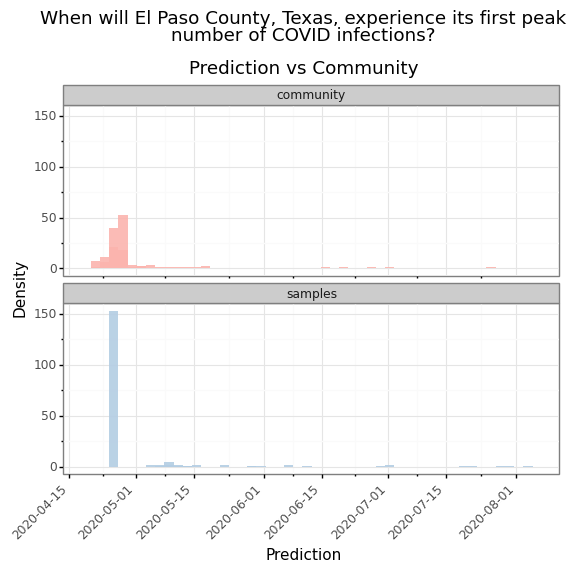

In [21]:
@question(4128, community_weight=0.5, community_fn=peak_infection_date_community)
def peak_infection_date() -> date:
    """
    When will El Paso County, Texas, experience its first peak number of COVID
    infections?
    
    From https://pandemic.metaculus.com/questions/4128:
    'This question resolves as the date for which
    the 2-day simple moving average(SMA) of the number of reported new infections
    is strictly greater than the 2-day SMA over the subsequent 10 days.'
    """
    end_date = date(2020, 7, 1)
    for today in daterange(START_DATE, end_date):
        sma_today = sma_infections(today)
        future_smas = [sma_infections(today + timedelta(i)) for i in range(1,11)]
        if sma_today > max(future_smas):
            return today
    return end_date

plot_question(peak_infection_date)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,95.0,37.14,28.11,25.0,25.00,25.0,34.0,149.00
peak_infections,200.0,83.57,316.05,0.0,63.92,74.0,74.0,4513.18


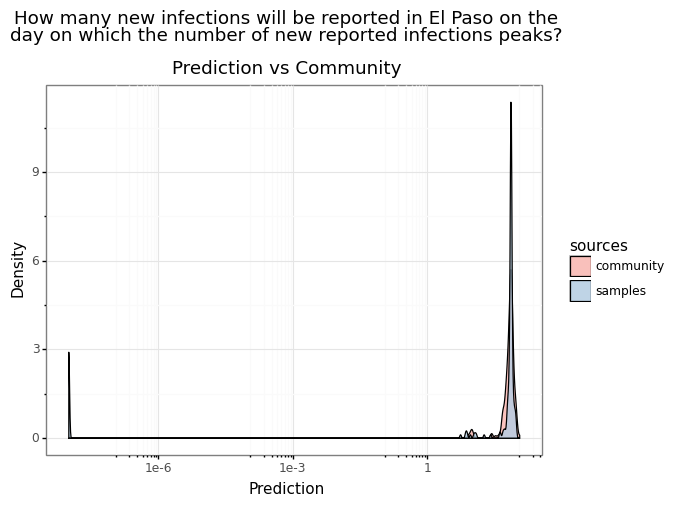

In [22]:
@question(4137, community_weight=0.5)
def peak_infections():
    """
    How many new infections will be reported in El Paso on the day on which
    the number of new reported infections peaks?
    """
    peak = peak_infection_date()
    return daily_infections(peak)
plot_question(peak_infections)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,111.0,36.88,29.08,25.0,25.00,25.00,25.00,140.00
mean_infections_peak345,200.0,74.59,322.41,0.0,27.44,31.67,31.67,2472.53


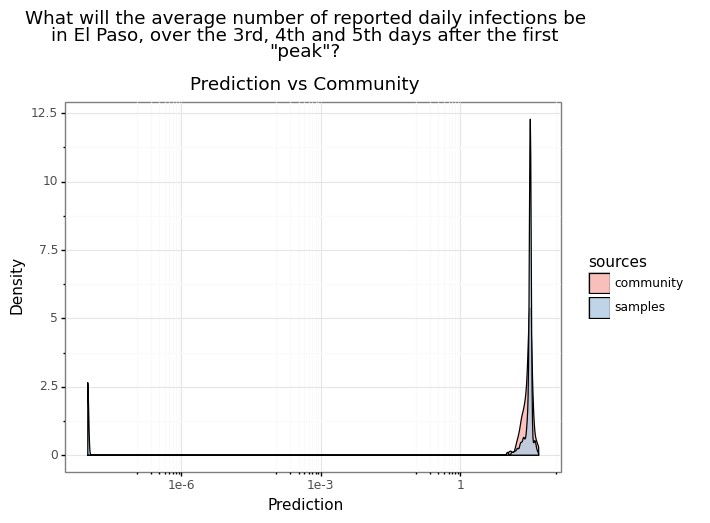

In [23]:
@question(4152, community_weight=0.5)
def mean_infections_peak345():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 3rd, 4th and 5th days after the first "peak"?
    """
    peak = peak_infection_date()
    return mean_infections(peak + timedelta(3), peak + timedelta(6))
plot_question(mean_infections_peak345)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,48.0,34.23,26.21,25.0,25.00,25.00,25.00,139.00
mean_infections_peak678,200.0,43.70,248.45,0.0,21.58,24.67,29.19,3535.56


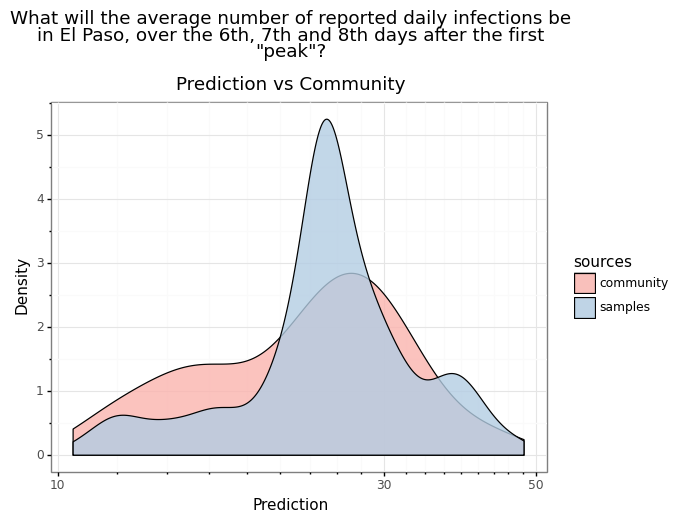

In [24]:
@question(4170, community_weight=0.8)
def mean_infections_peak678():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 6th, 7th and 8th days after the first "peak"?  
    """
    peak = peak_infection_date()
    return mean_infections(peak + timedelta(6), peak + timedelta(9))
plot_question(mean_infections_peak678)

,count,mean,std,min,25%,50%,75%,max
frac_patients_icu,200.0,0.31,0.09,0.08,0.26,0.31,0.37,0.61


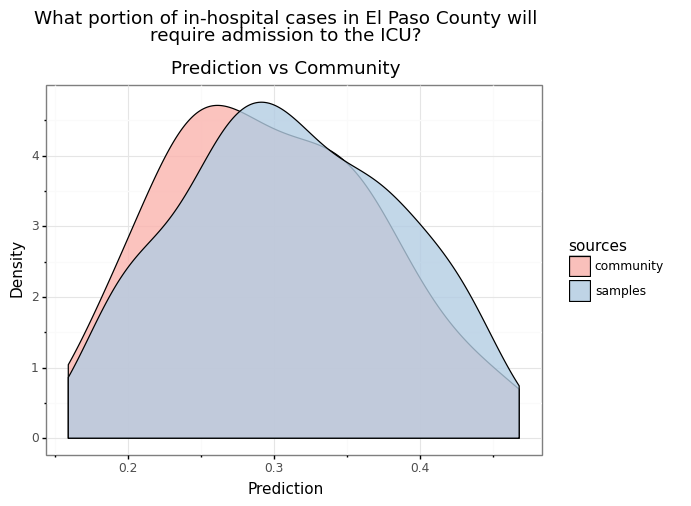

In [25]:
@question(4155, community_weight=0.7)
def frac_patients_icu():
    """
    What portion of in-hospital cases in El Paso County will require admission
    to the ICU?

    Following @katifish's approach:
    https://pandemic.metaculus.com/questions/4155/#comment-28054

    TODO: Add others from katifish comment
    """
    alpha = 0.1 # Rescaling counts becase we're more uncertain than implied by counts
    return ergo.random_choice([
      ergo.beta_from_hits(alpha * 121, alpha * 508),
      ergo.beta_from_hits(alpha * 181, alpha * 507),
    ])
plot_question(frac_patients_icu)

,count,mean,std,min,25%,50%,75%,max
frac_patients_icu,133.0,0.29,0.12,0.05,0.21,0.28,0.36,0.94
frac_patients_invasive,200.0,0.15,0.07,0.00,0.11,0.14,0.19,0.49


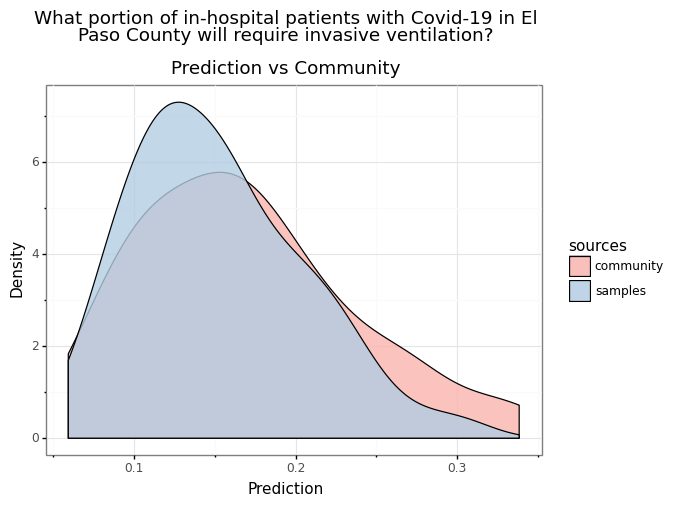

In [26]:
@question(4154, community_weight=0.3)
def frac_patients_invasive():
    """
    What portion of in-hospital patients with Covid-19 in El Paso County will
    require invasive ventilation?

    Following @PabloStafforini's indirect estimation approach:
    https://pandemic.metaculus.com/questions/4154/#comment-28155

    TODO:
    - Combine with direct estimate
      direct_estimate = ergo.beta_from_hits(0.1 * 130, 0.1 * 393)
    """
    return frac_patients_icu() * frac_icu_ventilation()
plot_question(frac_patients_invasive)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,136.0,36.64,28.33,25.0,25.00,25.0,25.0,140.00
max_30d_hospital_confirmed_for_peak,200.0,167.68,952.08,0.0,64.93,65.0,65.0,9914.06


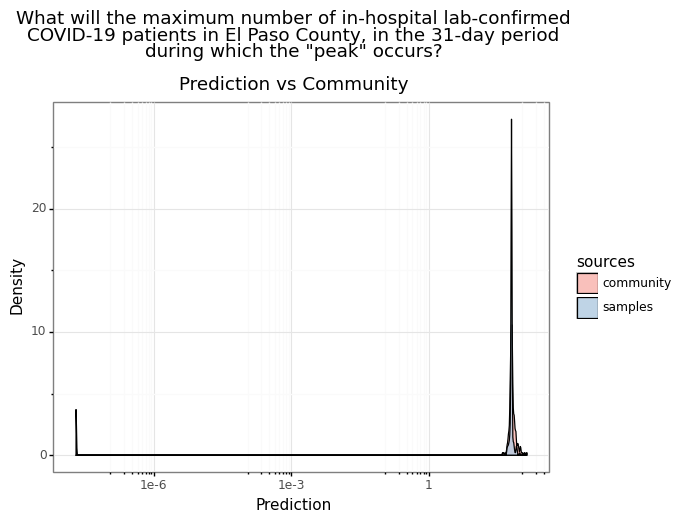

In [27]:
@question(4153, community_weight=0.3)
def max_30d_hospital_confirmed_for_peak():
    """
    What will the maximum number of in-hospital lab-confirmed COVID-19 
    patients in El Paso County, in the 30-day period during which the "peak"
    occurs?
    """
    peak = peak_infection_date()
    days = daterange(peak - timedelta(15), peak + timedelta(15))
    return max(hospital_confirmed_for_date(day) for day in days)

plot_question(max_30d_hospital_confirmed_for_peak, bw=0.01)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,139.0,37.10,29.23,25.00,25.00,25.00,25.00,140.00
frac_patients_icu,200.0,0.30,0.12,0.01,0.22,0.29,0.37,0.82
max_30d_hospital_confirmed_for_peak,200.0,123.30,836.83,0.00,65.00,65.00,65.00,11872.53
peak_icu_admissions,200.0,51.91,458.51,0.00,12.69,17.95,23.52,6497.40


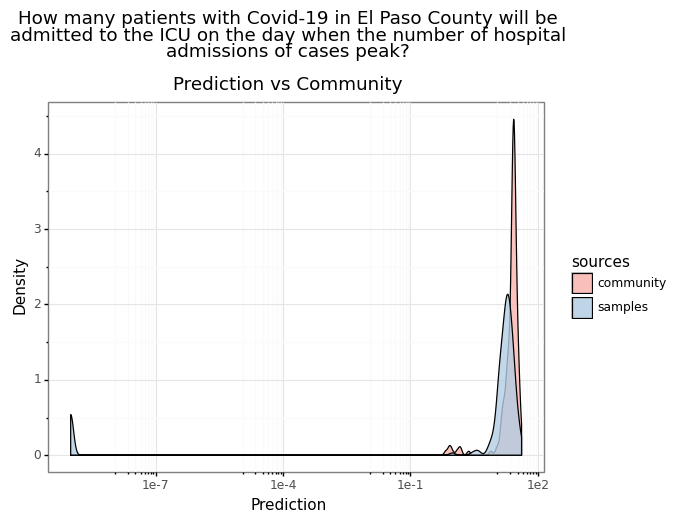

In [28]:
@question(4204)
def peak_icu_admissions():
    """
    How many patients with Covid-19 in El Paso County will be admitted to the
    ICU on the day when the number of hospital admissions of cases peak?

    Following @Tamay's approach:
    https://pandemic.metaculus.com/questions/4204/

    Alternative:    
    - peak = peak_hospitalizations_date()
    - return daily_icu_admissions(peak)

    FIXME: Admissions vs in-hospital patients unclear

    Not mixing in community since this is just the product of two other questions.    
    """
    max_patients = max_30d_hospital_confirmed_for_peak()
    return max_patients * frac_patients_icu()
plot_question(peak_icu_admissions)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,142.0,31.94,21.50,25.00,25.00,25.00,25.00,137.00
frac_patients_icu,200.0,0.31,0.10,0.04,0.25,0.31,0.37,0.85
max_30d_hospital_confirmed_for_peak,200.0,102.66,490.48,0.00,65.00,65.00,65.00,6947.11
peak_icu_admissions,200.0,33.64,180.12,0.00,14.60,19.83,24.95,2557.64
peak_invasive_ventilation,200.0,17.13,91.49,0.00,7.59,10.03,12.60,1299.11


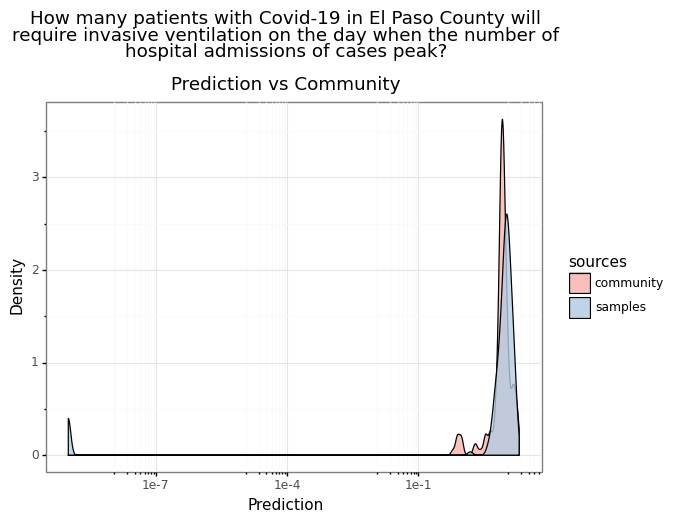

In [29]:
@question(4201)
def peak_invasive_ventilation():
    """
    How many patients with Covid-19 in El Paso County will require invasive 
    ventilation on the day when the number of hospital admissions of cases 
    peak?

    Following @Tamay's approach:
    https://pandemic.metaculus.com/questions/4201/#comment-28004

    Not mixing in community since this is just the product of two other questions.
    """
    return frac_icu_ventilation() * peak_icu_admissions()

plot_question(peak_invasive_ventilation)

# Generate predictions for all questions



In [30]:
def model():
    clear_mem()
    for sampler in samplers.values():
        sampler()

samples = ergo.run(model, num_samples=2000)

summarize_question_samples(samples)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,2000.0,35.34,25.43,25.0,25.00,25.00,25.00,145.00
peak_infections,2000.0,105.50,481.35,0.0,65.93,74.00,74.00,7870.75
mean_infections_peak345,2000.0,40.83,172.76,0.0,26.15,31.67,31.67,3935.02
mean_infections_peak678,2000.0,48.33,247.60,0.0,18.81,24.67,28.40,3300.08
frac_patients_icu,2000.0,0.30,0.10,0.0,0.23,0.29,0.36,0.79
frac_patients_invasive,2000.0,0.15,0.06,0.0,0.11,0.15,0.19,0.73
max_30d_hospital_confirmed_for_peak,2000.0,215.21,1279.40,0.0,65.00,65.00,65.00,16757.47
peak_icu_admissions,2000.0,61.20,380.01,0.0,13.58,18.74,23.82,6133.58
peak_invasive_ventilation,2000.0,31.26,196.49,0.0,6.78,9.50,12.24,3306.46


# Compare predictions to community



This takes a while since we're fitting a mixture of logistic
  distributions to our samples before visualizing (and submitting) them.
  These may look a little different from the plots for the  questions shown
  above, because we've taken more samples from the distribution and we're
  fitting logistic distributions so we can submit them to metaculus



Encoutered nan gradient, stopping early
[[ 126.68489 -200.04666  427.76266]
 [       nan        nan -769.61395]
 [ 194.27519 -441.37946  341.8513 ]]
[[ 0.65063024  0.7135747  -3.0450218 ]
 [ 0.35965785  0.04117648 -2.914145  ]
 [ 0.6171702   0.9553144  -3.040833  ]]



Encoutered nan gradient, stopping early
[[       nan        nan -682.08167]
 [ 215.21292 -464.88132  295.56458]
 [ 341.10114  513.76117  386.51712]]
[[ 0.35986573  0.04133442 -2.9427872 ]
 [ 0.6136286   1.0647426  -3.0594254 ]
 [ 0.5282049   0.2986936  -2.997787  ]]



Encoutered nan gradient, stopping early
[[  89.63666   113.361374  457.71655 ]
 [        nan         nan -763.9794  ]
 [ 229.54234  -602.6992    306.26285 ]]
[[ 0.41235122  0.5378544  -3.011975  ]
 [ 0.24075846  0.03982082 -2.9560223 ]
 [ 0.42275     0.99778336 -3.0320017 ]]


Encoutered nan gradient, stopping early
[[ 132.95728 -315.92786  407.36172]
 [ 159.58679 -391.13687  380.4508 ]
 [       nan        nan -787.8125 ]]
[[ 0.59396183  0.8916712  -3.0578258 ]
 [ 0.5532941   0.9715266  -3.0391319 ]
 [ 0.2434091   0.04237626 -2.9030418 ]]



Encoutered nan gradient, stopping early
[[ 128.41656     -2.7256775  437.2546   ]
 [ 129.95161   -248.03741    400.40182  ]
 [         nan          nan -837.65643  ]]
[[ 0.61935604  0.62471545 -3.0331535 ]
 [ 0.73803514  0.83826786 -3.086366  ]
 [ 0.19504887  0.04217746 -2.8804812 ]]


Encoutered nan gradient, stopping early
[[ 149.13287 -344.19464  383.54163]
 [       nan        nan -754.62317]
 [ 388.4477   414.39368  371.0815 ]]
[[ 0.6566691   0.8220989  -3.0861764 ]
 [ 0.1975316   0.04295458 -2.920928  ]
 [ 0.4603144   0.32815453 -2.9928973 ]]



Encoutered nan gradient, stopping early
[[ 113.17976 -235.03438  462.70825]
 [ 144.94286 -340.22247  412.8195 ]
 [       nan        nan -875.5277 ]]
[[ 0.64793694  0.74649966 -3.0498857 ]
 [ 0.66138923  0.9027529  -3.0626087 ]
 [ 0.22441038  0.03735912 -2.8875053 ]]


Encoutered nan gradient, stopping early
[[ 307.42502  523.45605  421.95474]
 [       nan        nan -779.5985 ]
 [ 210.30669 -553.8727   357.6438 ]]
[[ 0.41180733  0.2794862  -2.9983263 ]
 [ 0.22508061  0.03802874 -2.9490485 ]
 [ 0.51802504  0.87371427 -3.0526285 ]]


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Encoutered nan gradient, stopping early
[[ 138.87756 -223.2403   401.73953]
 [ 168.07983 -373.01218  369.53268]
 [       nan        nan -771.2722 ]]
[[ 0.7614213   0.7152274  -3.0404    ]
 [ 0.73458195  0.8098838  -3.0393982 ]
 [ 0.49415326  0.03896387 -2.920202  ]]



Encoutered nan gradient, stopping early
[[ 126.12932  -88.58353  418.3977 ]
 [ 182.70132 -424.78418  348.53668]
 [       nan        nan -766.9344 ]]
[[ 0.7338254   0.63623965 -3.0255516 ]
 [ 0.78138125  0.8715594  -3.0542562 ]
 [ 0.49144933  0.03654041 -2.9201906 ]]



Encoutered nan gradient, stopping early
[[       nan        nan -729.35376]
 [ 219.87364 -599.05347  325.08545]
 [ 133.11806   72.14096  404.26828]]
[[ 0.41312903  0.03946853 -2.9500444 ]
 [ 0.6254358   0.8066267  -3.0341384 ]
 [ 0.60281634  0.54320455 -3.015817  ]]



Encoutered nan gradient, stopping early
[[ 189.04001 -428.24402  321.11594]
 [ 165.755    231.26987  409.17606]
 [       nan        nan -730.292  ]]
[[ 0.7280095   0.98897874 -3.0595293 ]
 [ 0.69052035  0.4887748  -3.0189412 ]
 [ 0.41499338  0.04133833 -2.9215295 ]]



/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


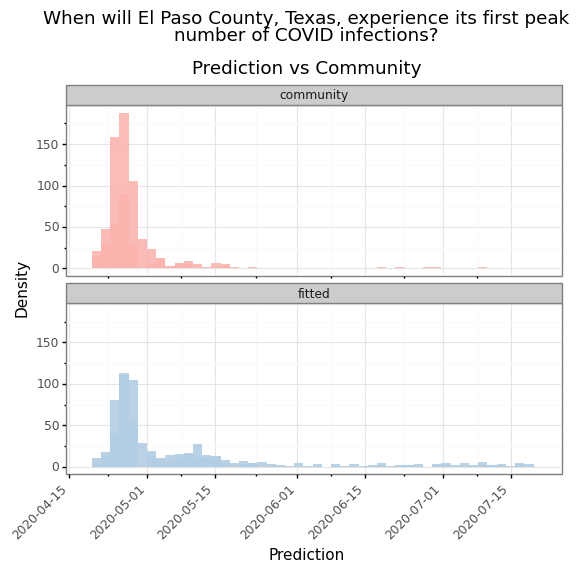

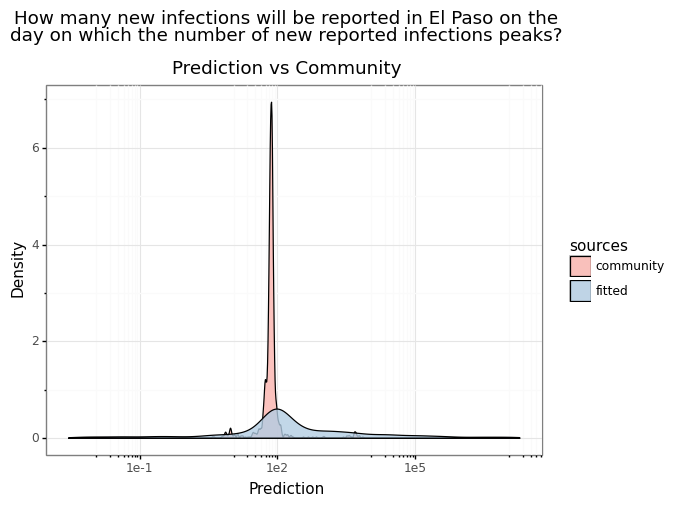

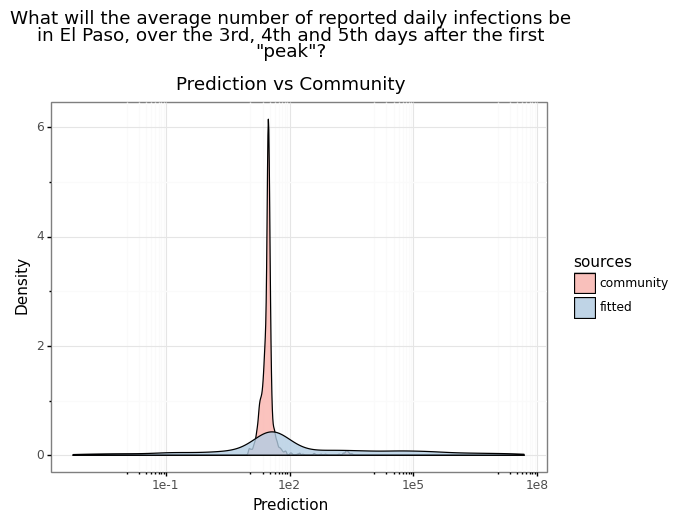

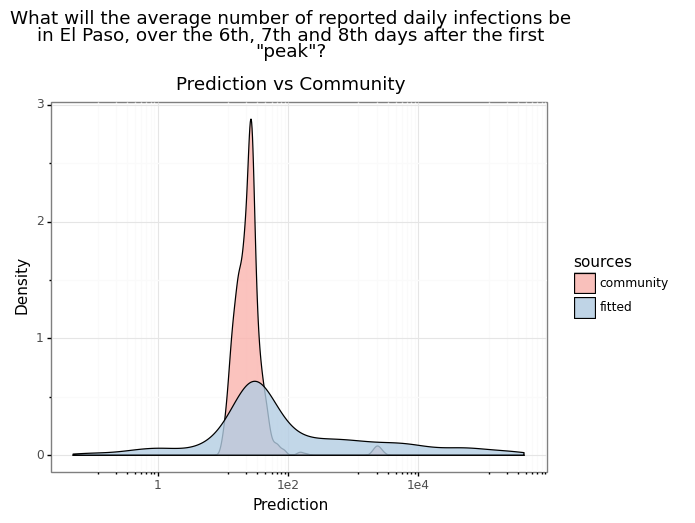

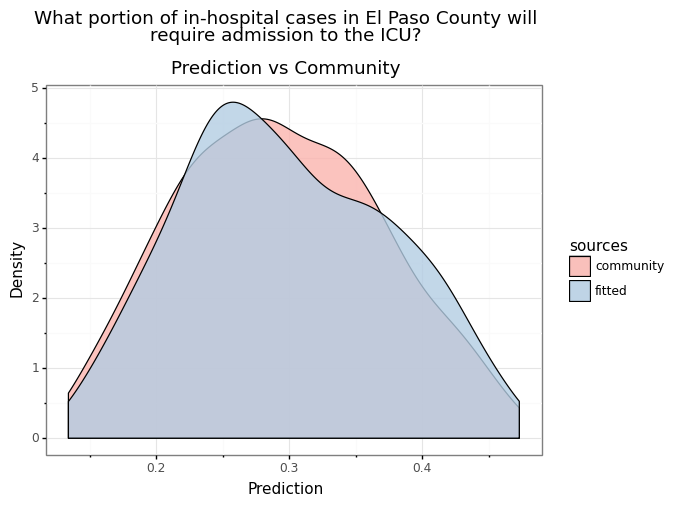

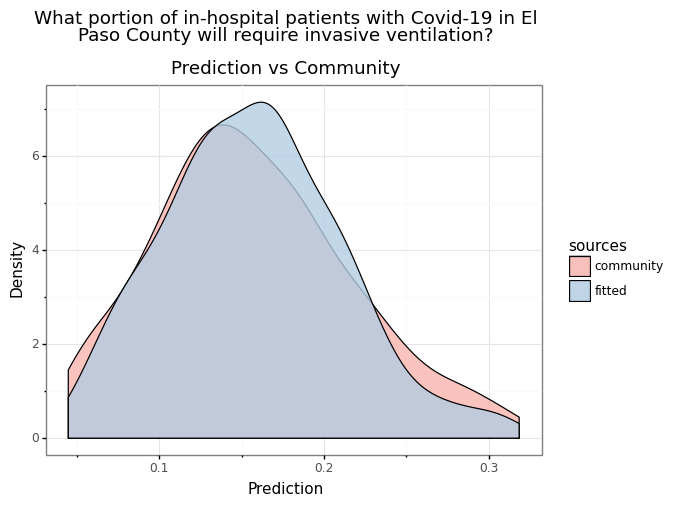

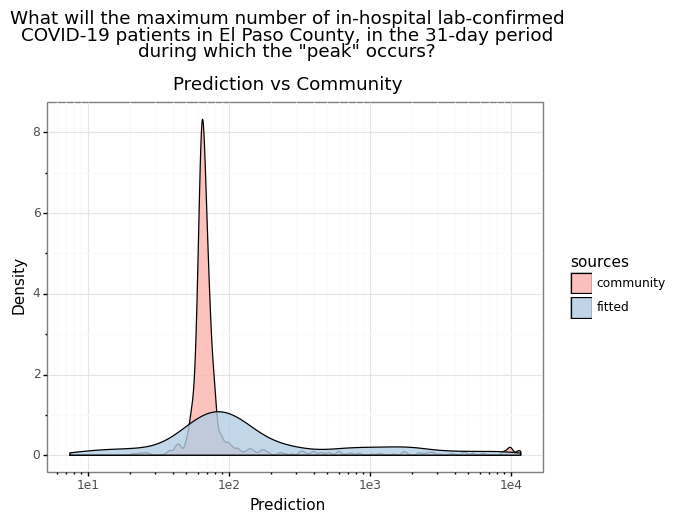

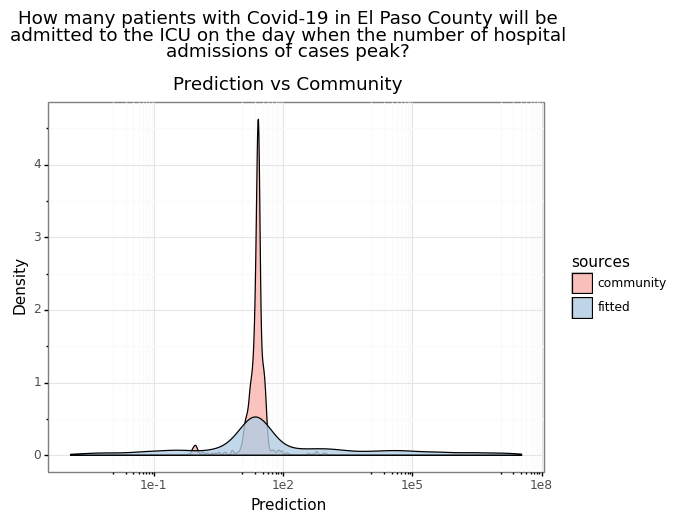

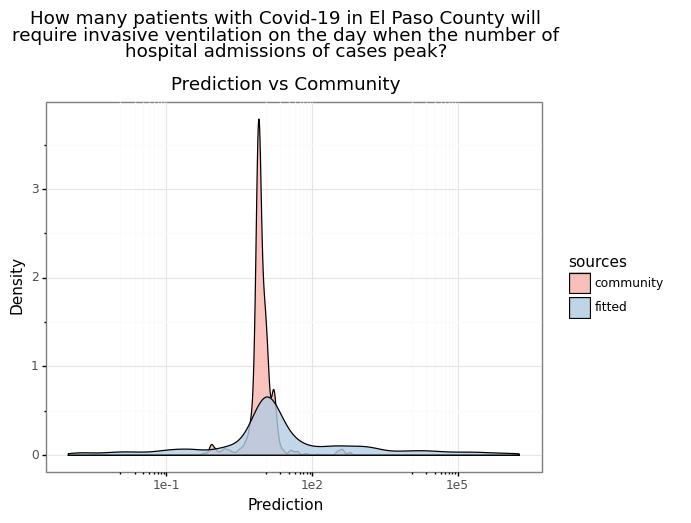

In [31]:
submissions = {}
for sampler in samplers.values():
    q = sampler.question

    q_samples = samples[sampler.__name__]

    if q.id == 4128: # Date question: Need to convert back to date from days (https://github.com/oughtinc/ergo/issues/144)
        q_samples = np.array([START_DATE + timedelta(s) for s in q_samples])

    if q.id in [4201, 4204, 4137, 4152, 4170, 4153]:
      # Clip extreme values for questions that we had issues fitting
      (sample_min, sample_max) = np.quantile(q_samples, [0.04, 0.96])
      q_samples = q_samples[(q_samples >= sample_min) & (q_samples <= sample_max)]

    submission = q.get_submission_from_samples(q_samples)
    submissions[q] = submission

    # the graph for this question will be too zoomed out unless we cut off more of the graph
    if q.id == 4153:
      q.show_prediction(q_samples, plot_samples=False, plot_fitted=True, show_community=True, percent_kept=0.7)
    else:
      q.show_prediction(q_samples, plot_samples=False, plot_fitted=True, show_community=True, percent_kept=0.9)

In [0]:
# Should we submit this to Metaculus? If so, uncomment the following lines:
# for q, submission in submissions.items():  
#     print(q.submit(submission))